Fitting 5 folds for each of 90 candidates, totalling 450 fits
✅ Mejor configuración: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10}
✅ ROC AUC Score: 0.816

📊 Matriz de Confusión:
 [[773 260]
 [101 273]]

📋 Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.88      0.75      0.81      1033
           1       0.51      0.73      0.60       374

    accuracy                           0.74      1407
   macro avg       0.70      0.74      0.71      1407
weighted avg       0.79      0.74      0.76      1407



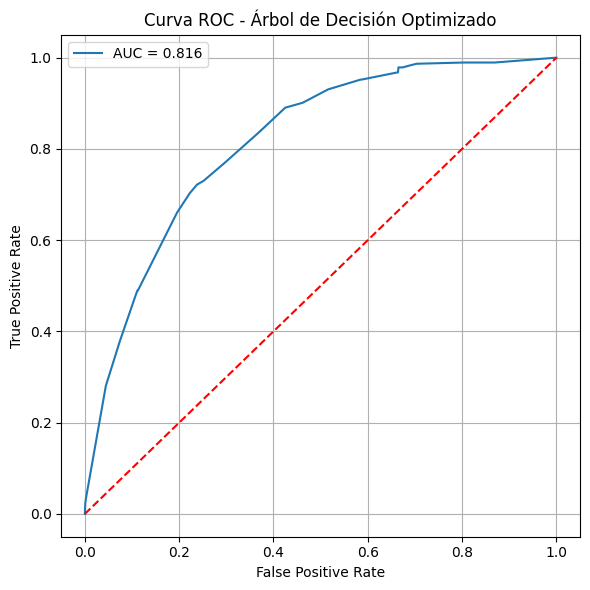

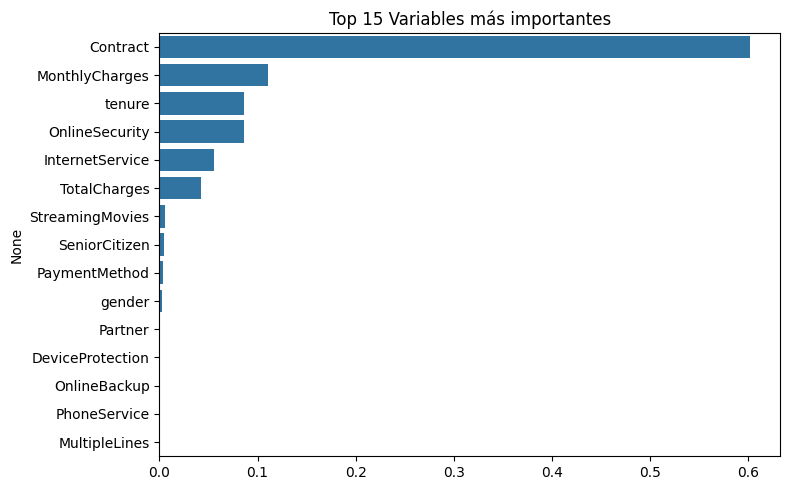

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Cargar y limpiar datos
df = pd.read_csv("teleco_clean.csv")
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

#Eliminar outliers en variables numéricas
for col in ['tenure', 'MonthlyCharges', 'TotalCharges']:
    Q1, Q3 = df[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    df = df[(df[col] >= Q1 - 1.5 * IQR) & (df[col] <= Q3 + 1.5 * IQR)]

X = df.drop(columns=['Churn'])
y = df['Churn']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42)

param_grid = {
    'max_depth': [3, 5, 7, 9, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

grid = GridSearchCV(
    DecisionTreeClassifier(class_weight='balanced', random_state=42),
    param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_proba)
print(f"✅ Mejor configuración: {grid.best_params_}")
print(f"✅ ROC AUC Score: {auc:.3f}\n")
print("📊 Matriz de Confusión:\n", confusion_matrix(y_test, y_pred))
print("\n📋 Reporte de Clasificación:\n", classification_report(y_test, y_pred))

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Árbol de Decisión Optimizado")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#Importancia de variables
importances = pd.Series(best_model.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(15)
    
plt.figure(figsize=(8, 5))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Top 15 Variables más importantes")
plt.tight_layout()
plt.show()
